In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import shape
import matplotlib.ticker as ticker
%matplotlib inline

import math

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:5

In [2]:
df = pd.read_csv('d1.csv', on_bad_lines='skip')
print("Length of original data : ", len(df))

# 计算每小时的平均值并另存为新数据帧
data2 =[]   
for i in range (len(df)//12):
    data2.append(df[i * 12:(i + 1) * 12].mean())
data2 = pd.DataFrame(data2)
print("Length of hourly averaged data : ", len(data2))

# 6-11列的数据
data = data2.iloc[:, 5:11].values

Length of original data :  17568
Length of hourly averaged data :  1464


In [3]:
# 查看位置
import os
print(os.path.abspath('.'))

D:\a_study\model\chuneng\WindChaser-master - 副本\data


In [4]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [5]:
rnn_unit = 10 
input_size = 5     # 表示输入层为5，数据为6-11列，实际使用7-11做输入预测6的结果，可以理解为输入层有5个节点
output_size=1      # 表示输出层的维度是1，实际输出第6列的结果


# 大概占0.68306，简单理解成训练集和测试集7：3
train_begin = 0
train_end = math.ceil(len(data2) * 0.7)
test_begin = math.ceil(len(data2) * 0.7)

test_len = 180   # 测试数据的长度
# iter_time = 100  # 迭代次数
iter_time = 100  # 迭代次数

# RNN 输出节点权重和偏差
# 决定rnn单元的输出和下一步的状态
weights = {
           'in':tf.Variable(tf.random.normal([input_size,rnn_unit])),
           'out':tf.Variable(tf.random.normal([rnn_unit,1]))
           }

biases = {
          'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
          'out':tf.Variable(tf.constant(0.1,shape=[1,]))
          }

In [6]:
def get_train_data(batch_size, time_step, train_begin, train_end):
    batch_index = []
    
     
    
    # 规范化数据
    scaler_for_x = MinMaxScaler(feature_range=(0, 1))
    scaled_x_data = scaler_for_x.fit_transform(data)
    
    scaler_for_y = MinMaxScaler(feature_range=(0, 1))
    scaled_y_data = scaler_for_y.fit_transform(data[:, 0].reshape(-1, 1))
    

    # 获得训练数据
    normalized_train_data = scaled_x_data[train_begin:train_end]
    train_x, train_y = [], []
    for i in range(len(normalized_train_data) - time_step):
        if i % batch_size == 0:
            batch_index.append(i)
        x = normalized_train_data[i:i + time_step, 1:6]
        y = normalized_train_data[i+1:i + time_step+1, 0, np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    
    batch_index.append((len(normalized_train_data) - time_step))
    return batch_index, train_x, train_y 

In [7]:
# 获取测试数据功能：LSTM 的负载测试数据
# 输入: time_step, test_begin, test_len
# 输出: test_x, test_y, scaler_for_x, scaler_for_y

def get_test_data(time_step, test_begin, test_len):
    
    # 规范化数据
    scaler_for_x = MinMaxScaler(feature_range=(0, 1))   # 归一化处理 minmaxscaler
    scaler_for_y = MinMaxScaler(feature_range=(0, 1))
    scaled_x_data = scaler_for_x.fit_transform(data)
    scaled_y_data = scaler_for_y.fit_transform(data[:, 0].reshape(-1, 1))
    
    # 获得测试数据
    size = test_len// time_step    # 用于计算测试集数据的数量
    normalized_test_data = scaled_x_data[test_begin: (test_begin+test_len)]
    normalized_test_lable = scaled_x_data[test_begin+1: (test_begin+test_len+1)]
    test_y = normalized_test_lable[:,0]
    test_x = []
    for i in range(size):
        x = normalized_test_data[i * time_step:(i + 1) * time_step, 1:6]
        test_x.append(x.tolist())
    return test_x, test_y, scaler_for_x, scaler_for_y

In [8]:
# LSTM 函数：循环神经网络的定义 定义的是lstm层
# 输入: X
# 输出: pred, final_states

def lstm(X):
    batch_size = tf.shape(X)[0]
    time_step = tf.shape(X)[1]
    w_in = weights['in']
    b_in = biases['in']
    
    # reshape to (batch_size * time_step, input_size)
    input = tf.reshape(X, [-1, input_size])  #将张量转换为 3D 数组作为隐藏层的输入
    input_rnn = tf.matmul(input, w_in) + b_in
    input_rnn = tf.reshape(input_rnn, [-1, time_step, rnn_unit])
    
    # 创建要展开的 LSTM 单元
    cell = tf.contrib.rnn.BasicLSTMCell(rnn_unit)
    
    # 在每个时间步，重新初始化隐藏状态
    init_state = cell.zero_state(batch_size, dtype=tf.float32)
    
    # 生成预测
    # 在 TensorFlow 中创建一个动态 RNN 对象。
    # 此对象将在每个时间步长动态执行 LSTM 单元的展开
    output_rnn, final_states = tf.nn.dynamic_rnn(cell, input_rnn, initial_state=init_state,
                                                 dtype=tf.float32)
    
    output = tf.reshape(output_rnn, [-1, rnn_unit])
    w_out = weights['out']
    b_out = biases['out']
    ## 获取最后输出
    pred = tf.matmul(output, w_out) + b_out
    pred = tf.identity(pred, name='my_pred')  # 这里为 pred 操作指定一个新的名称
    
    return pred, final_states

In [9]:
def train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len):
    # 设置状态存储/提取
    X = tf.placeholder(tf.float32, shape=[None, time_step, input_size], name='input_placeholder')
    # X = tf.placeholder(tf.float32, shape=[None, time_step, input_size])
    


    Y = tf.placeholder(tf.float32, shape=[None, time_step, output_size])    
    batch_index, train_x, train_y = get_train_data(batch_size, time_step, train_begin, train_end)
    
    pred, _ = lstm(X)
    
    pred = tf.identity(pred, name="pre_output")
    
    ## Loss and optimizer 损失和优化器
    loss = tf.reduce_mean(tf.square(tf.reshape(pred, [-1]) - tf.reshape(Y, [-1])))
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)
    loss_list = []
    print("Training begins: *****************************************************")
    
    
    ## 训练步骤优化
    """
    累积损失以监控培训进度。
    20 次迭代通常足以达到可接受的精度。    
    """
    
    with tf.Session() as sess:
        # 初始化变量
        sess.run(tf.global_variables_initializer())
        # 重复训练 100 次
        for epoch in range(iter_time):
            for step in range(len(batch_index) - 2):
                ## 计算批量损失 loss
                _, loss_ = sess.run([train_op, loss], feed_dict={X: train_x[batch_index[step]:batch_index[step + 1]],
                                                                 Y: np.array(train_y[batch_index[step]:batch_index[step + 1]], dtype=float).reshape(batch_size,time_step,1)})
                loss_list.append(loss_)
            
            # Show loss every 5 iterations   
            if epoch % 5 == 0:
                print("Epoch:", epoch, " loss:",loss_)
            
                #if step%100==0:
                    #print('Epoch:', epoch, 'steps: ', step,  'loss:', loss_)
        
        
        
        
        print("Training Optimization Finished! ***************************************")
          
        """Testing the model"""
        print("Prediction Begins: ****************************************************")
        test_x, test_y, scaler_for_x, scaler_for_y = get_test_data(time_step, test_begin, test_len)
        print("Shape of testing samples:", shape(test_x))

                      
        test_predict = []
        for step in range(len(test_x)):
            prob = sess.run(pred, feed_dict={X: [test_x[step]]})
            predict = prob.reshape((-1))
            test_predict.extend(predict)
        
        test_y = np.array(test_y).reshape(-1,1)
        test_predict = np.array(test_predict).reshape(-1,1) 
        print("Shape of testing lables:", shape(test_predict))
        test_predict = scaler_for_y.inverse_transform(test_predict).reshape(-1,1)
        test_y= scaler_for_y.inverse_transform(test_y).reshape(-1,1)
       
        
        # 计算预测误差 
        rmse = np.sqrt(mean_squared_error(test_predict, test_y))
        mae = mean_absolute_error(y_pred=test_predict, y_true=test_y)
        print ("Mean absolute error:", "{:.3f}".format(mae), 
               "Root mean squared error:", "{:.3f}".format(rmse))
        
        # 可视化
        figure = plt.figure(figsize=(8,5))
        
        axes = figure.add_subplot(1, 1, 1)
        axes.plot(test_y, lw='2', c = 'red', label='Real Testing Data')     
        axes.plot(test_predict, lw='2', c = 'darkblue', label='LSTM Forecasted Data')
        axes.set_title('Real Testing vs. Forecasted Wind Power', fontsize = 12)
        axes.set_xlabel('Time Series', fontsize = 12)
        axes.set_ylabel('Wind Power(MWh)', fontsize = 12)
       
        axes.legend(fontsize=12)
        

        
    return test_y, test_predict, loss_list, rmse, mae

# 优化

In [11]:
def fitness_function(lstm_params, batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len):
    # 调用训练和评估函数获取预测结果和实际标签
    y_pred_validation, y_true_validation = train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len, lstm_params)

    # 使用均方根误差（RMSE）作为适应度函数
    rmse = np.sqrt(mean_squared_error(y_true_validation, y_pred_validation))
    
    return rmse

In [12]:
# 定义粒子群算法中的更新速度和位置函数
def update_particle(particle, global_best_position, inertia_weight, c1, c2, search_space):
    # 更新速度
    particle['velocity'] = inertia_weight * particle['velocity'] + \
                           c1 * np.random.rand() * (particle['best_position'] - particle['position']) + \
                           c2 * np.random.rand() * (global_best_position - particle['position'])
    
    # 更新位置
    particle['position'] = particle['position'] + particle['velocity']
    
    # 限制参数在搜索空间范围内
    for i in range(len(particle['position'])):
        particle['position'][i] = np.clip(particle['position'][i], search_space[i][0], search_space[i][1])


In [13]:
# 定义将粒子参数映射到LSTM参数的函数
def convert_particle_to_lstm_params(particle_position):
    lstm_params = {
        'lr': particle_position[0],
        'batch_size': int(search_space['batch_size'][0]),
        'time_step': int(search_space['time_step'][0])
    }
    return lstm_params

In [14]:
# 主函数
# 定义粒子群算法主函数
def particle_swarm_optimization(iterations, num_particles, search_space):
    # 初始化粒子群
    particles = [{'position': np.random.uniform(low=search_space[param][0], high=search_space[param][1], size=1),
                  'velocity': np.zeros(1),
                  'best_position': None,
                  'best_fitness': float('inf')} for param in search_space.keys()]

    global_best_position = None
    global_best_fitness = float('inf')

    # 主循环
    for iteration in range(iterations):
        for i, particle in enumerate(particles):
            # 输出粒子的位置
            print("Particle Position:", particle['position'])
            # 计算适应度
            lstm_params = convert_particle_to_lstm_params(particle['position'])
            fitness = fitness_function(lstm_params)

            # 更新个体最优解
            if fitness < particle['best_fitness']:
                particle['best_position'] = np.copy(particle['position'])
                particle['best_fitness'] = fitness

            # 更新全局最优解
            if fitness < global_best_fitness:
                global_best_position = np.copy(particle['position'])
                global_best_fitness = fitness

            # 更新速度和位置
            update_particle(particle, global_best_position, inertia_weight, c1, c2, search_space.values())

        # 打印全局最优解
        print(f"Iteration {iteration + 1}: Global Best Fitness = {global_best_fitness}, Global Best Position = {global_best_position}")

        # 在每次迭代结束后，使用全局最优解的参数训练模型
        lstm_params = convert_particle_to_lstm_params(particle['position'])        # 加的
        fitness = fitness_function(lstm_params, batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len)

        y_pred_final, y_true_final = train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len, lstm_params)

        # 在这里可以根据需要进行其他操作，例如保存结果、打印输出等

    return global_best_position



# 定义超参数搜索空间范围
search_space = {
    'lr': (0.001, 0.1),
    'batch_size': (10, 64),
    'time_step': (5, 15)
}

In [15]:
search_space = {
    'lr': (0.001, 0.1),
    'batch_size': (10, 64),
    'time_step': (5, 15)
}

In [16]:
# 运行粒子群算法
best_hyperparameters = particle_swarm_optimization(iterations=50, num_particles=20, search_space=search_space)


Particle Position: [0.07213781]


TypeError: fitness_function() missing 7 required positional arguments: 'batch_size', 'time_step', 'train_begin', 'train_end', 'test_begin', 'iter_time', and 'test_len'

# 整的

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import shape
import math
import matplotlib.ticker as ticker
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
df = pd.read_csv('d1.csv', on_bad_lines='skip')
print("原始数据长度: ", len(df))

# 计算每小时的平均值并另存为新数据帧
data2 = []
for i in range(len(df) // 12):
    data2.append(df[i * 12:(i + 1) * 12].mean())
data2 = pd.DataFrame(data2)
print("每小时平均数据长度: ", len(data2))

data = data2.iloc[:, 5:11].values
rnn_unit = 10
input_size = 5
output_size = 1
train_begin = 0
train_end = math.ceil(len(data2) * 0.7)
test_begin = math.ceil(len(data2) * 0.7)
test_len = 180
iter_time = 100
# 寻优以下三个参数，先只选择lr
# lr=0.0006
batch_size = 14
time_step = 12

# RNN 输出节点权重和偏差
weights = {
    'in': tf.Variable(tf.random.normal([input_size, rnn_unit])),
    'out': tf.Variable(tf.random.normal([rnn_unit, 1]))
}
biases = {
    'in': tf.Variable(tf.constant(0.1, shape=[rnn_unit, ])),
    'out': tf.Variable(tf.constant(0.1, shape=[1, ]))
}


def get_train_data(batch_size, time_step, train_begin, train_end):
    batch_index = []
    scaler_for_x = MinMaxScaler(feature_range=(0, 1))
    scaled_x_data = scaler_for_x.fit_transform(data)
    scaler_for_y = MinMaxScaler(feature_range=(0, 1))
    scaled_y_data = scaler_for_y.fit_transform(data[:, 0].reshape(-1, 1))

    normalized_train_data = scaled_x_data[train_begin:train_end]
    train_x, train_y = [], []

    for i in range(len(normalized_train_data) - time_step):
        if i % batch_size == 0:
            batch_index.append(i)
        x = normalized_train_data[i:i + time_step, 1:6]
        y = normalized_train_data[i + 1:i + time_step + 1, 0, np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())

    batch_index.append((len(normalized_train_data) - time_step))
    return batch_index, train_x, train_y


def get_test_data(time_step, test_begin, test_len):
    scaler_for_x = MinMaxScaler(feature_range=(0, 1))
    scaler_for_y = MinMaxScaler(feature_range=(0, 1))
    scaled_x_data = scaler_for_x.fit_transform(data)
    scaled_y_data = scaler_for_y.fit_transform(data[:, 0].reshape(-1, 1))

    size = test_len // time_step
    normalized_test_data = scaled_x_data[test_begin: (test_begin + test_len)]
    normalized_test_lable = scaled_x_data[test_begin + 1: (test_begin + test_len + 1)]
    test_y = normalized_test_lable[:, 0]
    test_x = []

    for i in range(size):
        x = normalized_test_data[i * time_step:(i + 1) * time_step, 1:6]
        test_x.append(x.tolist())

    return test_x, test_y, scaler_for_x, scaler_for_y


def lstm(X):
    batch_size = tf.shape(X)[0]
    time_step = tf.shape(X)[1]
    w_in = weights['in']
    b_in = biases['in']

    input = tf.reshape(X, [-1, input_size])
    input_rnn = tf.matmul(input, w_in) + b_in
    input_rnn = tf.reshape(input_rnn, [-1, time_step, rnn_unit])

    cell = tf.contrib.rnn.BasicLSTMCell(rnn_unit)
    init_state = cell.zero_state(batch_size, dtype=tf.float32)

    output_rnn, final_states = tf.nn.dynamic_rnn(cell, input_rnn, initial_state=init_state, dtype=tf.float32)
    output = tf.reshape(output_rnn, [-1, rnn_unit])
    w_out = weights['out']
    b_out = biases['out']

    pred = tf.matmul(output, w_out) + b_out
    pred = tf.identity(pred, name='my_pred')

    return pred, final_states

def train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len, lstm_params):
# def train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len):
    X = tf.placeholder(tf.float32, shape=[None, time_step, input_size], name='input_placeholder')
    Y = tf.placeholder(tf.float32, shape=[None, time_step, output_size])
    # 加的
    batch_index, train_x, train_y = get_train_data(batch_size, time_step, train_begin, train_end)
    
    pred, _ = lstm(X)
    pred = tf.identity(pred, name="pre_output")

    loss = tf.reduce_mean(tf.square(tf.reshape(pred, [-1]) - tf.reshape(Y, [-1])))
    train_op = tf.train.AdamOptimizer(lstm_params['lr']).minimize(loss)
    loss_list = []
    print("Training begins: *****************************************************")

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(iter_time):
            for step in range(len(batch_index) - 2):
                _, loss_ = sess.run([train_op, loss],
                                    feed_dict={X: train_x[batch_index[step]:batch_index[step + 1]],
                                               Y: np.array(train_y[batch_index[step]:batch_index[step + 1]],
                                                           dtype=float).reshape(batch_size, time_step, 1)})
                loss_list.append(loss_)

            if epoch % 5 == 0:
                print("Epoch:", epoch, " loss:", loss_)

        print("Training Optimization Finished! ***************************************")

        print("Prediction Begins: ****************************************************")
        test_x, test_y, scaler_for_x, scaler_for_y = get_test_data(time_step, test_begin, test_len)
        print("Shape of testing samples:", shape(test_x))

        test_predict = []
        for step in range(len(test_x)):
            prob = sess.run(pred, feed_dict={X: [test_x[step]]})
            predict = prob.reshape((-1))
            test_predict.extend(predict)

        test_y = np.array(test_y).reshape(-1, 1)
        test_predict = np.array(test_predict).reshape(-1, 1)
        print("Shape of testing lables:", shape(test_predict))
        test_predict = scaler_for_y.inverse_transform(test_predict).reshape(-1, 1)
        test_y = scaler_for_y.inverse_transform(test_y).reshape(-1, 1)

        rmse = np.sqrt(mean_squared_error(test_predict, test_y))
        mae = mean_absolute_error(y_pred=test_predict, y_true=test_y)
        print("Mean absolute error:", "{:.3f}".format(mae),
              "Root mean squared error:", "{:.3f}".format(rmse))

        figure = plt.figure(figsize=(8, 5))

        axes = figure.add_subplot(1, 1, 1)
        axes.plot(test_y, lw='2', c='red', label='Real Testing Data')
        axes.plot(test_predict, lw='2', c='darkblue', label='LSTM Forecasted Data')
        axes.set_title('Real Testing vs. Forecasted Wind Power', fontsize=12)
        axes.set_xlabel('Time Series', fontsize=12)
        axes.set_ylabel('Wind Power(MWh)', fontsize=12)

        axes.legend(fontsize=12)

    return test_y, test_predict, loss_list, rmse, mae

C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:5

原始数据长度:  17568
每小时平均数据长度:  1464


In [2]:
import numpy as np
import tensorflow as tf
from pyswarms.single.global_best import GlobalBestPSO
from sklearn.metrics import mean_squared_error
from pyswarms.utils.functions import single_obj as fx
import pyswarms as ps


def fitness_function(lstm_params):
    test_y, test_predict, _, _, _ = train_lstm(14, 10, train_begin, train_end, test_begin, iter_time, test_len, lstm_params)
    rmse = np.sqrt(mean_squared_error(test_y, test_predict))
    return rmse

def convert_particle_to_lstm_params(particle_position):
    lstm_params = {'lr': particle_position[0]}
    return lstm_params

# Set the bounds for lr
constraints = (np.array([-np.pi , -np.pi/2 , 1 , -np.pi , -5*np.pi/36 , -np.pi]),
               np.array([np.pi  ,  np.pi/2 , 3 ,  np.pi ,  5*np.pi/36 ,  np.pi]))

# search_space = (0.001, 0.01)
search_space = (0.001, np.pi)

# Define other hyperparameters
options = {'c1': 2.0, 'c2': 2.0, 'w': 0.5}

# Create the particle swarm optimizer
# optimizer = GlobalBestPSO(n_particles=20, dimensions=1, options=options, bounds=[search_space])
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=1, options=options, bounds = constraints)

# Define the objective function (fitness function)
def objective_function(particle_position):
    lstm_params = convert_particle_to_lstm_params(particle_position)
    return fitness_function(lstm_params)

# Run the optimization
best_position, _ = optimizer.optimize(objective_function, iters=50)

# Display the results
print("Best lr:", best_position[0])


2024-03-20 10:08:12,410 - pyswarms.backend.generators - ERROR - Bounds and/or init_pos should be of size (1,)
Traceback (most recent call last):
  File "C:\Users\82516\.conda\envs\tf1\lib\site-packages\pyswarms\backend\generators.py", line 82, in generate_swarm
    low=min_bounds, high=max_bounds, size=(n_particles, dimensions)
  File "mtrand.pyx", line 1131, in numpy.random.mtrand.RandomState.uniform
  File "_common.pyx", line 562, in numpy.random._common.cont
  File "_common.pyx", line 480, in numpy.random._common.cont_broadcast_2
  File "_common.pyx", line 229, in numpy.random._common.validate_output_shape
ValueError: Output size (20, 1) is not compatible with broadcast dimensions of inputs (20, 6).


ValueError: Output size (20, 1) is not compatible with broadcast dimensions of inputs (20, 6).



Particle Position: [0.00825899]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Training begins: *****************************************************
Epoch: 0  loss: 0.071854435
Epoch: 5  loss: 0.009554449
Epoch: 10  l

UnboundLocalError: local variable 'global_best_fitness' referenced before assignment

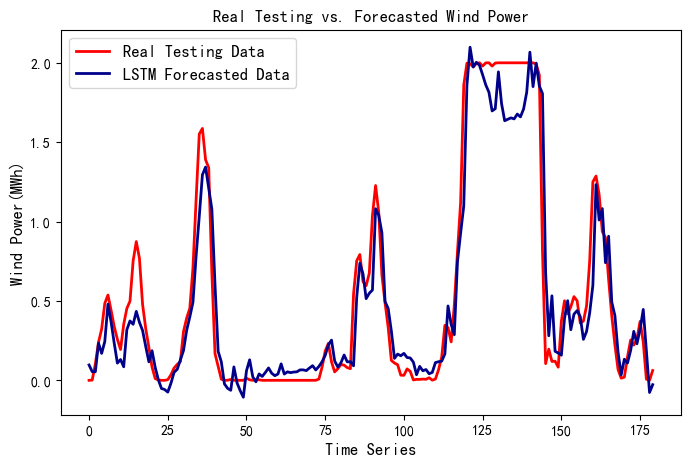

In [2]:
def fitness_function(lstm_params):
    test_y, test_predict, loss_list, rmse, mae= train_lstm(14, 10, train_begin, train_end, test_begin, iter_time,
                                               test_len, lstm_params)
    y_pred_validation = test_predict
    y_true_validation = test_y
    
    rmse = np.sqrt(mean_squared_error(y_true_validation, y_pred_validation))

    return rmse


def update_particle(particle, global_best_position, inertia_weight, c1, c2, lr_range):
    particle['velocity'] = inertia_weight * particle['velocity'] + \
                           c1 * np.random.rand() * (particle['best_position'] - particle['position']) + \
                           c2 * np.random.rand() * (global_best_position - particle['position'])

    particle['position'] = particle['position'] + particle['velocity']

# 下面这个函数有点问题
def convert_particle_to_lstm_params(particle_position):
    lstm_params = {
        'lr': particle_position[0], 
    }
    return lstm_params


def particle_swarm_optimization(iterations, num_particles, search_space):
    
    # with tf.Graph().as_default():
    
    # particles = [{'position': np.random.uniform(low=search_space['lr'][0], high=search_space['lr'][1], size=1),
    #               'velocity': np.zeros(1),
    #               'best_position': None,
    #               'best_fitness': float('inf')}]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        particles = [{'position': np.random.uniform(low=search_space['lr'][0], high=search_space['lr'][1], size=1),
                  'velocity': np.zeros(1),
                  'best_position': None,
                  'best_fitness': float('inf')} for _ in range(num_particles)]

        for iteration in range(iterations):
    #         # 清除默认图和重启会话
    #         tf.compat.v1.reset_default_graph()
    #         session = tf.compat.v1.Session()

    #         graph = tf.Graph()  # 创建新的图形
    #         with graph.as_default():
            for i, particle in enumerate(particles):
                print("Particle Position:", particle['position'])
                lstm_params = convert_particle_to_lstm_params(particle['position'])
                fitness = fitness_function(lstm_params)

                if fitness < particle['best_fitness']:
                    particle['best_position'] = np.copy(particle['position'])
                    particle['best_fitness'] = fitness

                if fitness < global_best_fitness:
                    global_best_position = np.copy(particle['position'])
                    global_best_fitness = fitness

                update_particle(particle, global_best_position, inertia_weight, c1, c2, search_space['lr'])

            lstm_params = convert_particle_to_lstm_params(global_best_position)
            fitness = fitness_function(lstm_params)
            print(f"Iteration {iteration + 1}: Global Best lr = {global_best_position[0]}, Global Best Fitness = {global_best_fitness}")

            # 在训练开始前显示选定的 lr 值
            print("Selected lr for training:", global_best_position[0])
            print("lr:", lstm_params['lr'])

            batch_size = 14   # 每个batch中样本的数量
            time_step = 12
            test_y, test_predict, loss_list, rmse, mae= train_lstm(14, 10, train_begin, train_end, test_begin, iter_time,
                                                   test_len, lstm_params)
            y_pred_final = test_predict
            y_true_final = test_y
    return global_best_position


# 定义超参数搜索空间范围
search_space = {'lr': (0.001, 0.01),}

# 定义其他超参数
inertia_weight = 0.5
c1 = 2.0
c2 = 2.0

# 运行粒子群算法
best_hyperparameters = particle_swarm_optimization(iterations=50, num_particles=20, search_space=search_space)


Particle Position: [0.00547982]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Training begins: *****************************************************


Epoch: 0  loss: 0.0030494994
Epoch: 5  loss: 0.0066179144
Epoch: 10 

UnboundLocalError: local variable 'global_best_fitness' referenced before assignment

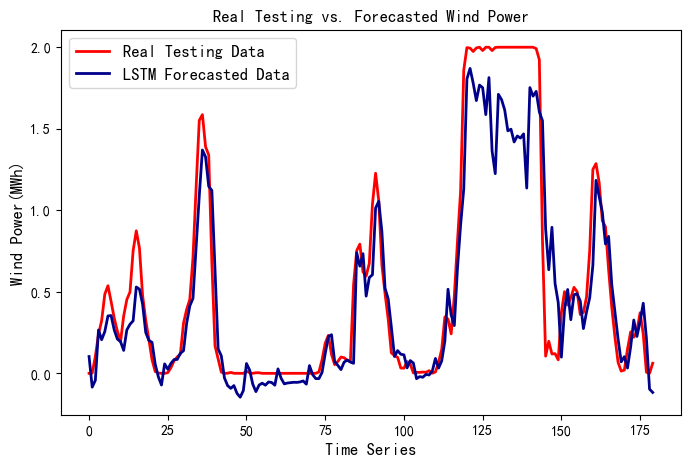

In [2]:
def fitness_function(lstm_params):
    # y_pred_validation, y_true_validation = train_lstm(batch_size, time_step, train_begin, train_end, test_begin,
    #                                                   iter_time, test_len, lstm_params)

    # y_pred_validation, y_true_validation = train_lstm(batch_size, time_step, train_begin, train_end, test_begin,
    #                                                   iter_time, test_len, lstm_params)
    test_y, test_predict, loss_list, rmse, mae= train_lstm(14, 10, train_begin, train_end, test_begin, iter_time,
                                               test_len, lstm_params)
    y_pred_validation = test_predict
    y_true_validation = test_y
    
    rmse = np.sqrt(mean_squared_error(y_true_validation, y_pred_validation))

    return rmse


def update_particle(particle, global_best_position, inertia_weight, c1, c2, lr_range):
    particle['velocity'] = inertia_weight * particle['velocity'] + \
                           c1 * np.random.rand() * (particle['best_position'] - particle['position']) + \
                           c2 * np.random.rand() * (global_best_position - particle['position'])

    particle['position'] = particle['position'] + particle['velocity']

# 下面这个函数有点问题
def convert_particle_to_lstm_params(particle_position):
    lstm_params = {
        'lr': particle_position[0], 
    }
    return lstm_params


def particle_swarm_optimization(iterations, num_particles, search_space):
    
    # with tf.Graph().as_default():
    
    # particles = [{'position': np.random.uniform(low=search_space['lr'][0], high=search_space['lr'][1], size=1),
    #               'velocity': np.zeros(1),
    #               'best_position': None,
    #               'best_fitness': float('inf')}]
    particles = [{'position': np.random.uniform(low=search_space['lr'][0], high=search_space['lr'][1], size=1),
              'velocity': np.zeros(1),
              'best_position': None,
              'best_fitness': float('inf')} for _ in range(num_particles)]

    for iteration in range(iterations):
#         # 清除默认图和重启会话
#         tf.compat.v1.reset_default_graph()
#         session = tf.compat.v1.Session()

#         graph = tf.Graph()  # 创建新的图形
#         with graph.as_default():
        for i, particle in enumerate(particles):
            print("Particle Position:", particle['position'])
            lstm_params = convert_particle_to_lstm_params(particle['position'])
            fitness = fitness_function(lstm_params)

            if fitness < particle['best_fitness']:
                particle['best_position'] = np.copy(particle['position'])
                particle['best_fitness'] = fitness

            if fitness < global_best_fitness:
                global_best_position = np.copy(particle['position'])
                global_best_fitness = fitness

            update_particle(particle, global_best_position, inertia_weight, c1, c2, search_space['lr'])

        lstm_params = convert_particle_to_lstm_params(global_best_position)
        fitness = fitness_function(lstm_params)
        print(f"Iteration {iteration + 1}: Global Best lr = {global_best_position[0]}, Global Best Fitness = {global_best_fitness}")

        # 在训练开始前显示选定的 lr 值
        print("Selected lr for training:", global_best_position[0])
        print("lr:", lstm_params['lr'])

        batch_size = 14   # 每个batch中样本的数量
        time_step = 12
        test_y, test_predict, loss_list, rmse, mae= train_lstm(14, 10, train_begin, train_end, test_begin, iter_time,
                                               test_len, lstm_params)
        y_pred_final = test_predict
        y_true_final = test_y
    return global_best_position


# 定义超参数搜索空间范围
search_space = {'lr': (0.001, 0.01),}

# 定义其他超参数
inertia_weight = 0.5
c1 = 2.0
c2 = 2.0

# 运行粒子群算法
best_hyperparameters = particle_swarm_optimization(iterations=50, num_particles=20, search_space=search_space)


# 备份

In [2]:
def fitness_function(lstm_params):
    # y_pred_validation, y_true_validation = train_lstm(batch_size, time_step, train_begin, train_end, test_begin,
    #                                                   iter_time, test_len, lstm_params)

    y_pred_validation, y_true_validation = train_lstm(lstm_params['batch_size'], lstm_params['time_step'], train_begin, train_end, test_begin,
                                                      iter_time, test_len, lstm_params)

    
    rmse = np.sqrt(mean_squared_error(y_true_validation, y_pred_validation))

    return rmse


def update_particle(particle, global_best_position, inertia_weight, c1, c2, search_space):
    particle['velocity'] = inertia_weight * particle['velocity'] + \
                           c1 * np.random.rand() * (particle['best_position'] - particle['position']) + \
                           c2 * np.random.rand() * (global_best_position - particle['position'])

    particle['position'] = particle['position'] + particle['velocity']

    for i in range(len(particle['position'])):
        particle['position'][i] = np.clip(particle['position'][i], search_space[i][0], search_space[i][1])

# 下面这个函数有点问题
def convert_particle_to_lstm_params(particle_position):
    lstm_params = {
        'lr': particle_position[0],
        'batch_size': int(particle_position[0]),
        'time_step': int(particle_position[0])
    }
    return lstm_params


def particle_swarm_optimization(iterations, num_particles, search_space):
    particles = [{'position': np.random.uniform(low=search_space[param][0], high=search_space[param][1], size=1),
                  'velocity': np.zeros(1),
                  'best_position': None,
                  'best_fitness': float('inf')} for param in search_space.keys()]

    global_best_position = None
    global_best_fitness = float('inf')

    for iteration in range(iterations):
        for i, particle in enumerate(particles):
            print("Particle Position:", particle['position'])
            lstm_params = convert_particle_to_lstm_params(particle['position'])
            fitness = fitness_function(lstm_params)

            if fitness < particle['best_fitness']:
                particle['best_position'] = np.copy(particle['position'])
                particle['best_fitness'] = fitness

            if fitness < global_best_fitness:
                global_best_position = np.copy(particle['position'])
                global_best_fitness = fitness

            update_particle(particle, global_best_position, inertia_weight, c1, c2, search_space.values())

        # print(f"Iteration {iteration + 1}: Global Best Fitness = {global_best_fitness}, Global Best Position = {global_best_position}")

        
        
        lstm_params = convert_particle_to_lstm_params(global_best_position)
        fitness = fitness_function(lstm_params)
        
        print("batch_size")
        print(batch_size)
            
        # if lstm_params['batch_size'] <= 0:
        #     lstm_params['batch_size'] = 1  # 设置一个默认值，也可以根据具体情况进行调整
        
        y_pred_final, y_true_final = train_lstm(lstm_params['batch_size'], lstm_params['time_step'], train_begin, train_end, test_begin, iter_time,
                                               test_len, lstm_params)
        
    return global_best_position


# 定义超参数搜索空间范围
search_space = {
    'lr': (0.001, 0.1),
    'batch_size': (10, 64),
    'time_step': (5, 15)
}

# 定义其他超参数
inertia_weight = 0.5
c1 = 2.0
c2 = 2.0

# 运行粒子群算法
best_hyperparameters = particle_swarm_optimization(iterations=50, num_particles=20, search_space=search_space)


Particle Position: [0.07537059]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Training begins: *****************************************************




ValueError: Cannot feed value of shape (14, 10, 5) for Tensor 'input_placeholder:0', which has shape '(?, 0, 5)'

# 网格

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import shape
import math
import matplotlib.ticker as ticker
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
df = pd.read_csv('d1.csv', on_bad_lines='skip')
print("原始数据长度: ", len(df))

# 计算每小时的平均值并另存为新数据帧
data2 = []
for i in range(len(df) // 12):
    data2.append(df[i * 12:(i + 1) * 12].mean())
data2 = pd.DataFrame(data2)
print("每小时平均数据长度: ", len(data2))

data = data2.iloc[:, 5:11].values
rnn_unit = 10
input_size = 5
output_size = 1
train_begin = 0
train_end = math.ceil(len(data2) * 0.7)
test_begin = math.ceil(len(data2) * 0.7)
test_len = 180
iter_time = 100
# 寻优以下三个参数，先只选择lr
# lr=0.0006
batch_size = 14
time_step = 12

# RNN 输出节点权重和偏差
weights = {
    'in': tf.Variable(tf.random.normal([input_size, rnn_unit])),
    'out': tf.Variable(tf.random.normal([rnn_unit, 1]))
}
biases = {
    'in': tf.Variable(tf.constant(0.1, shape=[rnn_unit, ])),
    'out': tf.Variable(tf.constant(0.1, shape=[1, ]))
}


def get_train_data(batch_size, time_step, train_begin, train_end):
    batch_index = []
    scaler_for_x = MinMaxScaler(feature_range=(0, 1))
    scaled_x_data = scaler_for_x.fit_transform(data)
    scaler_for_y = MinMaxScaler(feature_range=(0, 1))
    scaled_y_data = scaler_for_y.fit_transform(data[:, 0].reshape(-1, 1))

    normalized_train_data = scaled_x_data[train_begin:train_end]
    train_x, train_y = [], []

    for i in range(len(normalized_train_data) - time_step):
        if i % batch_size == 0:
            batch_index.append(i)
        x = normalized_train_data[i:i + time_step, 1:6]
        y = normalized_train_data[i + 1:i + time_step + 1, 0, np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())

    batch_index.append((len(normalized_train_data) - time_step))
    return batch_index, train_x, train_y


def get_test_data(time_step, test_begin, test_len):
    scaler_for_x = MinMaxScaler(feature_range=(0, 1))
    scaler_for_y = MinMaxScaler(feature_range=(0, 1))
    scaled_x_data = scaler_for_x.fit_transform(data)
    scaled_y_data = scaler_for_y.fit_transform(data[:, 0].reshape(-1, 1))

    size = test_len // time_step
    normalized_test_data = scaled_x_data[test_begin: (test_begin + test_len)]
    normalized_test_lable = scaled_x_data[test_begin + 1: (test_begin + test_len + 1)]
    test_y = normalized_test_lable[:, 0]
    test_x = []

    for i in range(size):
        x = normalized_test_data[i * time_step:(i + 1) * time_step, 1:6]
        test_x.append(x.tolist())

    return test_x, test_y, scaler_for_x, scaler_for_y


def lstm(X):
    batch_size = tf.shape(X)[0]
    time_step = tf.shape(X)[1]
    w_in = weights['in']
    b_in = biases['in']

    input = tf.reshape(X, [-1, input_size])
    input_rnn = tf.matmul(input, w_in) + b_in
    input_rnn = tf.reshape(input_rnn, [-1, time_step, rnn_unit])

    cell = tf.contrib.rnn.BasicLSTMCell(rnn_unit)
    init_state = cell.zero_state(batch_size, dtype=tf.float32)

    output_rnn, final_states = tf.nn.dynamic_rnn(cell, input_rnn, initial_state=init_state, dtype=tf.float32)
    output = tf.reshape(output_rnn, [-1, rnn_unit])
    w_out = weights['out']
    b_out = biases['out']

    pred = tf.matmul(output, w_out) + b_out
    pred = tf.identity(pred, name='my_pred')

    return pred, final_states

def train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len, lstm_params):
    # 重置 TensorFlow 默认图
    # tf.reset_default_graph()
# def train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len):
    X = tf.placeholder(tf.float32, shape=[None, time_step, input_size], name='input_placeholder')
    Y = tf.placeholder(tf.float32, shape=[None, time_step, output_size])
    # 加的
    batch_index, train_x, train_y = get_train_data(batch_size, time_step, train_begin, train_end)
    
    pred, _ = lstm(X)
    pred = tf.identity(pred, name="pre_output")

    loss = tf.reduce_mean(tf.square(tf.reshape(pred, [-1]) - tf.reshape(Y, [-1])))
    train_op = tf.train.AdamOptimizer(lstm_params['lr']).minimize(loss)
    loss_list = []
    print("Training begins: *****************************************************")

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(iter_time):
            for step in range(len(batch_index) - 2):
                _, loss_ = sess.run([train_op, loss],
                                    feed_dict={X: train_x[batch_index[step]:batch_index[step + 1]],
                                               Y: np.array(train_y[batch_index[step]:batch_index[step + 1]],
                                                           dtype=float).reshape(batch_size, time_step, 1)})
                loss_list.append(loss_)

            if epoch % 5 == 0:
                print("Epoch:", epoch, " loss:", loss_)

        print("Training Optimization Finished! ***************************************")

        print("Prediction Begins: ****************************************************")
        test_x, test_y, scaler_for_x, scaler_for_y = get_test_data(time_step, test_begin, test_len)
        print("Shape of testing samples:", shape(test_x))

        test_predict = []
        for step in range(len(test_x)):
            prob = sess.run(pred, feed_dict={X: [test_x[step]]})
            predict = prob.reshape((-1))
            test_predict.extend(predict)

        test_y = np.array(test_y).reshape(-1, 1)
        test_predict = np.array(test_predict).reshape(-1, 1)
        print("Shape of testing lables:", shape(test_predict))
        test_predict = scaler_for_y.inverse_transform(test_predict).reshape(-1, 1)
        test_y = scaler_for_y.inverse_transform(test_y).reshape(-1, 1)

        rmse = np.sqrt(mean_squared_error(test_predict, test_y))
        mae = mean_absolute_error(y_pred=test_predict, y_true=test_y)

    return test_y, test_predict, loss_list, rmse, mae

C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:5

原始数据长度:  17568
每小时平均数据长度:  1464


In [2]:
# 定义lr的搜索范围
lr_candidates = [0.001, 0.01, 0.1, 0.2, 0.5]

# 存储每个lr的性能指标
results = {}


# 网格搜索
for lr in lr_candidates:
    # 设置LSTM参数
    lstm_params = {'lr': lr}
    
    # 训练和评估模型
    test_y, test_predict, loss_list, rmse, mae = train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len, lstm_params)
    
    # 存储性能指标
    results[lr] = {'rmse': rmse, 'mae': mae}

# 打印每个lr的性能指标
for lr, metrics in results.items():
    print(f'lr={lr}: RMSE={metrics["rmse"]}, MAE={metrics["mae"]}')

# 选择最佳参数
best_lr = min(results, key=lambda x: results[x]['rmse'])
print(f'Best lr: {best_lr}')



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Training begins: *****************************************************


Epoch: 0  loss: 0.030652534
Epoch: 5  loss: 0.005701623
Epoch: 10  loss: 0.0037681398
Epoch: 15  los

ValueError: Variable rnn/basic_lstm_cell/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()
  File "C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 2023, in variable_v2
    shared_name=shared_name, name=name)


# ceshi

In [1]:
import numpy as np
import pyswarms as ps


def distance(query, target):
    x_dist = (target[0] - query[0])**2
    y_dist = (target[1] - query[1])**2
    z_dist = (target[2] - query[2])**2
    dist = np.sqrt(x_dist + y_dist + z_dist)
    return dist

swarm_size = 20
dim = 6        # Dimension of X
epsilon = 1.0
options = {'c1': 1.5, 'c2':1.5, 'w':0.5}

constraints = (np.array([-np.pi , -np.pi/2 , 1 , -np.pi , -5*np.pi/36 , -np.pi]),
               np.array([np.pi  ,  np.pi/2 , 3 ,  np.pi ,  5*np.pi/36 ,  np.pi]))

d1 = d2 = d3 = d4 = d5 = d6 = 3

def getTransformMatrix(theta, d, a, alpha):
    T = np.array([[np.cos(theta) , -np.sin(theta)*np.cos(alpha) ,  np.sin(theta)*np.sin(alpha) , a*np.cos(theta)],
                  [np.sin(theta) ,  np.cos(theta)*np.cos(alpha) , -np.cos(theta)*np.sin(alpha) , a*np.sin(theta)],
                  [0             ,  np.sin(alpha)               ,  np.cos(alpha)               , d              ],
                  [0             ,  0                           ,  0                           , 1              ]
                 ])
    return T

def get_end_tip_position(params):
    # Create the transformation matrices for the respective joints
    t_00 = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
    t_01 = getTransformMatrix(params[0] , d2        , 0 , -np.pi/2)
    t_12 = getTransformMatrix(params[1] , d2        , 0 , -np.pi/2)
    t_23 = getTransformMatrix(0         , params[2] , 0 , -np.pi/2)
    t_34 = getTransformMatrix(params[3] , d4        , 0 , -np.pi/2)
    t_45 = getTransformMatrix(params[4] , 0         , 0 ,  np.pi/2)
    t_56 = getTransformMatrix(params[5] , d6        ,0  ,  0)

    # Get the overall transformation matrix
    end_tip_m = t_00.dot(t_01).dot(t_12).dot(t_23).dot(t_34).dot(t_45).dot(t_56)

    # The coordinates of the end tip are the 3 upper entries in the 4th column
    pos = np.array([end_tip_m[0,3],end_tip_m[1,3],end_tip_m[2,3]])
    return pos

def opt_func(X):
    n_particles = X.shape[0]  # number of particles
    target = np.array([-2,2,3])
    dist = [distance(get_end_tip_position(X[i]), target) for i in range(n_particles)]
    return np.array(dist)


In [2]:
# Call an instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=swarm_size,
                                    dimensions=dim,
                                    options=options,
                                    bounds=constraints)

# Perform optimization
cost, joint_vars = optimizer.optimize(opt_func, iters=1000)

print(get_end_tip_position(joint_vars))


2024-03-20 10:04:58,403 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.026
2024-03-20 10:05:02,455 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.026026323091444644, best pos: [-2.05303089  1.03706884  1.93804127 -1.23078472 -0.43631707 -1.40235015]


[-2.01254672  2.01808042  2.98610584]
